In [1]:
!pip install python-chess==0.31.2
!pip install seaborn

  Using cached python_chess-0.31.2-py3-none-any.whl.metadata (12 kB)
Using cached python_chess-0.31.2-py3-none-any.whl (132 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [2]:
import chess
import sys
import torch
import random
from transformers import GPT2LMHeadModel, AutoModel
sys.path.append("src")
from data_utils.chess_tokenizer import ChessTokenizer
import chess.pgn as pgn
import io
import os
from datasets import load_dataset

import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import numpy as np
from scipy.spatial.distance import cosine
import re

2024-08-14 10:33:29.845604: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-14 10:33:29.895251: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def read_pgn_file(file_path):
    games = []
    with open(file_path, "r") as pgn_file:
        while True:
            game = chess.pgn.read_game(pgn_file)
            if game is None:
                break
            if(len(list(game.mainline_moves())) > 4):
            #if (game.headers["Termination"] == 'Normal'):
                games.append(game[0])
    return games

def get_legal_moves(board):
    legal_moves = set()
    for move in board.legal_moves:
        uci_move = board.uci(move)
        legal_moves.add(uci_move)
    return legal_moves


def chop_game_at_random_point(pgn):
    # Split the PGN string into individual moves
    moves = pgn.split()
    game_moves = [(re.sub(r'\d+\.', '', move).strip()) for move in moves]
    # Determine the total number of moves
    total_moves = len(game_moves)
    # Ensure we have an even number of moves for simplicity
    if total_moves % 2 != 0:
        total_moves -= 1
    # Randomly choose a point to chop, ensuring 50/50 white/black split
    random_index = random.randint(7, total_moves - 1)
    # Determine if the random point should be a white or black move
    if random_index % 2 == 0:
        chopped_game = ' '.join(moves[:random_index + 1])
        _next_after_chop = ' '.join(moves[:random_index + 2])
    else:
        chopped_game = ' '.join(moves[:random_index + 2])
        _next_after_chop = ' '.join(moves[:random_index + 3])

    #_next_after_chop= moves[random_index+2]
    return chopped_game, _next_after_chop

def chop_game_before_final_moves(pgn):
    moves = pgn.split()
    #game_moves = [move for move in moves if not move[0].isdigit()]
    game_moves = [(re.sub(r'\d+\.', '', move).strip()) for move in moves]
    total_moves = len(game_moves)
    if total_moves < 2 :
        chopped_game = ' '.join(moves)
        return 'skip'
    else:
        chopped_game = ' '.join(moves[:total_moves - 2])

    return chopped_game


def predict_move1(input_seq, tokenizer, model, n_tokens = 3):

    game_prefix = [tokenizer.bos_token_id]
    game_prefix_str = ""

    game_prefix.extend(tokenizer.encode(input_seq, add_special_tokens=False, get_move_end_positions=False))
    game_prefix_str += input_seq + " "

    greedy_game_prefix = list(game_prefix)
    prefix_tens = torch.tensor([greedy_game_prefix])
    pred_move = ""

    # default range is 3 tokens.
    for idx in range(n_tokens):
        logits = model(prefix_tens)[0]
        
        # logits is a 3-dimensional tensor with the shape [batch_size, sequence_length, vocab_size].
        # --> Extracting the logits for the last token.
        last_token_logit = logits[0, -1, :]

        token_idx = torch.argmax(last_token_logit).item()
        
        current_token = tokenizer.decode_token(token_idx)
        pred_move += current_token

        if idx == 0 and current_token == tokenizer.eos_token:
            break

        greedy_game_prefix += [token_idx]
        prefix_tens = torch.tensor([greedy_game_prefix])

    if len(pred_move) == 6:
        pred_move = pred_move[:4]

    legal_moves = get_legal_moves(board)
    if pred_move not in legal_moves:
        print("ILLEGAL MOVE")
        print(f"Legal moves: {legal_moves}")

    #print(f"LM plays: {pred_move}")
    return pred_move

def predict_half_legal_move1(input_seq, init_square):
    # To make the model predict only 'half' of the move, add initial square of the next move
    initial_square = init_square
    b2 = input_seq + " " + initial_square

    # and put n_tokens = 1
    predict_move1(b2, n_tokens = 1)

# probing to see if the game provides legal moves given the starting square
def probing_legal_moves1(input_seq0, board, tokenizer, model):
    legal_moves = get_legal_moves(board)
    illegal_count = 0
    for leg_move in legal_moves:

        initial_square = leg_move[:2]
        input_seq = input_seq0 + " " + initial_square

        game_prefix = [tokenizer.bos_token_id]
        game_prefix_str = ""

        game_prefix.extend(tokenizer.encode(input_seq, add_special_tokens=False, get_move_end_positions=False))
        game_prefix_str += input_seq + " "

        greedy_game_prefix = list(game_prefix)
        prefix_tens = torch.tensor([greedy_game_prefix])
        pred_move = ""

        for idx in range(1):
            logits = model(prefix_tens)[0]
        
            # logits is a 3-dimensional tensor with the shape [batch_size, sequence_length, vocab_size].
            # --> Extracting the logits for the last token.
            last_token_logit = logits[0, -1, :]

            token_idx = torch.argmax(last_token_logit).item()
            
            current_token = tokenizer.decode_token(token_idx)
            pred_move += current_token

            if idx == 0 and current_token == tokenizer.eos_token:
                break

            greedy_game_prefix += [token_idx]
            prefix_tens = torch.tensor([greedy_game_prefix])

            if len(pred_move) == 6:
                pred_move = pred_move[:4]

            pred_move = initial_square + pred_move
            if pred_move not in legal_moves:
            #print("ILLEGAL MOVE")
            #print(f"Legal moves: {legal_moves}")
                illegal_count += 1

            #print(f"LM plays: {pred_move}")

    #print(f"Ratio legal/total: {len(legal_moves)-illegal_count} / {len(legal_moves)}")
    return (len(legal_moves)-illegal_count), len(legal_moves)


In [4]:
# Initialize the Model and the Tokenizer

vocab_path = "vocab.txt"
tokenizer = ChessTokenizer(vocab_path)
model = GPT2LMHeadModel.from_pretrained('shtoshni/gpt2-chess-uci')

ds = load_dataset("adamkarvonen/chess_sae_individual_games_filtered")

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
# Next move prediction given game sequence (PGN) and probing on legal moves given all starting squares.

g = random.randint(0, 90000)
a = ds['train']['text'][g][1:]
b, c = chop_game_at_random_point(a)

b1 = io.StringIO(b)
game = pgn.read_game(b1)
board = game.board()

move_list = []
for move in game.mainline_moves():
    move_list.append(board.uci(move))
    board.push(move)
b1 = (" ".join(move_list))

print("PGN seq: ", b)
print("UCI seq: ", b1)

input_seq = b1
predicted_move = predict_move1(input_seq, tokenizer, model)


c1 = io.StringIO(c)
game_c = pgn.read_game(c1)
board_c = game_c.board()
move_list_c = []
for move_c in game_c.mainline_moves():
    move_list_c.append(board_c.uci(move_c))
    board_c.push(move_c)
c1 = (" ".join(move_list_c))


print(f"LM plays: {predicted_move}")
print(f"In the game it was: {c1[-4:]}")

In [ ]:
probed_legal_moves, tot = probing_legal_moves1(input_seq, board, tokenizer, model)
print("correct legal moves over total legal moves:", probed_legal_moves,"/", tot)

In [ ]:
# testing legal moves predicting on 2k games from hf dataset
# Ratio legal/total: 66028 / 67621 --> 97.64422294849233l

l = 0
t = 0
g1 = 1
for g in range(0,2000):
    b = chop_game_before_final_moves(ds['train']['text'][g][1:])
    b1 = io.StringIO(b)
    game = pgn.read_game(b1)
    board = game.board()

    move_list = []
    for move in game.mainline_moves():
        move_list.append(board.uci(move))
        board.push(move)
    b1 = (" ".join(move_list))

    input_seq = b1
    legal, total = probing_legal_moves1(input_seq, board, tokenizer, model)    
    l = l + legal
    t = t + total
    print(f"{g1} / {2000} ------- {legal} / {total} ---> Ratio legal/total: {l} / {t} --> {int(l/t*100)}%")
    g1 += 1

print(f"Ratio legal/total: {l} / {t} --> {(l/t)*100}")

In [ ]:
# testing legal moves predicting on my games on lichess (100% they are not on training set)
# still around 97% legal moves ratio

file_path = "/home/sagemaker-user/anlp/prob1/lichess_Mack9_2024-07-30.pgn"
games = read_pgn_file(file_path)

l = 0
t = 0
g1 = 1
for g in range(len(games)):
    b = chop_game_before_final_moves(str(games[g]))
    b1 = io.StringIO(b)
    game = pgn.read_game(b1)
    board = game.board()

    move_list = []
    for move in game.mainline_moves():
        move_list.append(board.uci(move))
        board.push(move)
    b1 = (" ".join(move_list))

    input_seq = b1
    legal, total = probing_legal_moves1(input_seq, board, tokenizer, model)   
    l = l + legal
    t = t + total
    print(f"{g1} / {2000} ------- {legal} / {total} ---> Ratio legal/total: {l} / {t} --> {int(l/t*100)}%")
    g1 += 1

print(f"Ratio legal/total: {l} / {t} --> {(l/t)*100}")

In [19]:
# ----------------------------
# Attention: Heatmap Probing
# ----------------------------


# Initialize the Model and the Tokenizer
vocab_path = "vocab.txt"
tokenizer = ChessTokenizer(vocab_path)
model = GPT2LMHeadModel.from_pretrained('shtoshni/gpt2-chess-uci')

num_heads = model.config.num_attention_heads
num_layers = len(model.transformer.h)
#print(f"Number of attention layers: {num_layers}")
#print(f"Number of heads: {num_heads}")

ds = load_dataset("adamkarvonen/chess_sae_individual_games_filtered")

def get_model_output(input_sequence):
    # Encode the input sequence
    encoded = tokenizer.encode(input_sequence, add_special_tokens=False, get_move_end_positions=False)
    # Convert to tensor and add batch dimension
    inputs = torch.tensor([encoded]).long()
    with torch.no_grad():
        outputs = model(inputs, output_attentions=True, output_hidden_states=True)
    return outputs

def visualize_attention0(input_sequence, layer=-1, head=0):
    outputs = get_model_output(input_sequence)
    attention = outputs.attentions[layer][0, head].cpu().numpy()

    decoded_tokens = [tokenizer.decode_token(t) for t in tokenizer.encode(input_sequence, add_special_tokens=False, get_move_end_positions=False)]
    
    plt.figure(figsize=(6, 4))
    #sns.heatmap(attention, cmap="YlOrRd")   #--> this for token number
    sns.heatmap(attention, cmap="YlOrRd", xticklabels=decoded_tokens, yticklabels=decoded_tokens)
    plt.title(f"Attention weights for layer {layer+1}, head {head+1}")
    plt.xlabel("Key tokens")
    plt.ylabel("Query tokens")
    plt.show()
    

def group_tokens(tokens):
    """Group tokens in pairs."""
    grouped_tokens = []
    for i in range(0, len(tokens), 2):
        if i + 1 < len(tokens):
            grouped_tokens.append(f"{tokens[i]}-{tokens[i + 1]}")
        else:
            grouped_tokens.append(tokens[i])  # Handle the case of an odd number of tokens
    return grouped_tokens

def aggregate_attention(attention, group_size):
    """Aggregate attention weights by summing over grouped tokens."""
    num_tokens = attention.shape[0]
    num_groups = (num_tokens + group_size - 1) // group_size  # Calculate number of groups

    aggregated_attention = np.zeros((num_groups, num_groups))

    for i in range(num_groups):
        for j in range(num_groups):
            start_i, end_i = i * group_size, min((i + 1) * group_size, num_tokens)
            start_j, end_j = j * group_size, min((j + 1) * group_size, num_tokens)
            aggregated_attention[i, j] = np.sum(attention[start_i:end_i, start_j:end_j])
    
    return aggregated_attention


def visualize_attention(input_sequence, layer=-1, head=0):

    outputs = get_model_output(input_sequence)
    attention = outputs.attentions[layer][0, head].cpu().numpy()

    decoded_tokens = [tokenizer.decode_token(t) for t in tokenizer.encode(input_sequence, add_special_tokens=False, get_move_end_positions=False)]
    grouped_tokens = group_tokens(decoded_tokens)

    # --> comment to show UCI notation, leave to show SAN move (UCI = c8-f5, SAN = Nf5)
    grouped_tokens = re.sub(r'\d+\.', '', str(game.mainline_moves())).split()

    grouped_attention = aggregate_attention(attention, group_size=2)  # Group size of 2 for pairs


    plt.figure(figsize=(6, 4))
    sns.heatmap(grouped_attention, cmap="YlOrRd", xticklabels=grouped_tokens, yticklabels=grouped_tokens)
    plt.title(f"Attention weights for layer {layer+1}, head {head+1}")
    plt.xlabel("Key Moves (2 tokens)")
    plt.ylabel("Query Moves (2 tokens)")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()


def probe_attention(move_sequence, query_key = 'moves'):
    moves = move_sequence.split()
    if query_key == 'moves':
        vis_att = visualize_attention
    else:
        vis_att = visualize_attention0

    if len(moves) < 3:
        print("The move sequence is too short for meaningful analysis.")
        return

    # Visualize attention for the whole sequence
    print("Visualizing attention for the entire move sequence:")

    num_layers = 1
    num_heads = 12
    for i in range(num_layers):
        vis_att(move_sequence, 7, 0)



def generate_average_heatmap(input_sequence, average_over='heads'):
    outputs = get_model_output(input_sequence)
    num_layers = len(outputs.attentions)
    num_heads = outputs.attentions[0].shape[1]
    
    if average_over == 'heads':
        # Average over heads for each layer
        avg_attention = [torch.mean(layer_output[0], dim=0).cpu().numpy() for layer_output in outputs.attentions]
    elif average_over == 'layers':
        # Average over layers for each head
        avg_attention = [torch.mean(torch.stack([layer[0, head] for layer in outputs.attentions]), dim=0).cpu().numpy() 
                         for head in range(num_heads)]
    else:
        raise ValueError("average_over must be either 'heads' or 'layers'")

    decoded_tokens = [tokenizer.decode_token(t) for t in tokenizer.encode(input_sequence, add_special_tokens=False, get_move_end_positions=False)]
    grouped_tokens = group_tokens(decoded_tokens)
    
    for i, attention in enumerate(avg_attention):
        grouped_attention = aggregate_attention(attention, group_size=2)
        
        plt.figure(figsize=(6, 4))
        sns.heatmap(grouped_attention, cmap="YlOrRd", xticklabels=grouped_tokens, yticklabels=grouped_tokens)
        
        if average_over == 'heads':
            plt.title(f"Average Attention Weights across Heads for Layer {i+1}")
        else:
            plt.title(f"Average Attention Weights across Layers for Head {i+1}")
        
        plt.xlabel("Key Moves (2 tokens)")
        plt.ylabel("Query Moves (2 tokens)")
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.show()


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Visualizing attention for the entire move sequence:


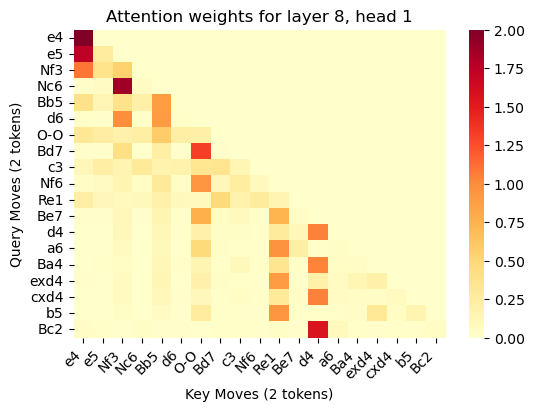

Visualizing attention for the entire move sequence:


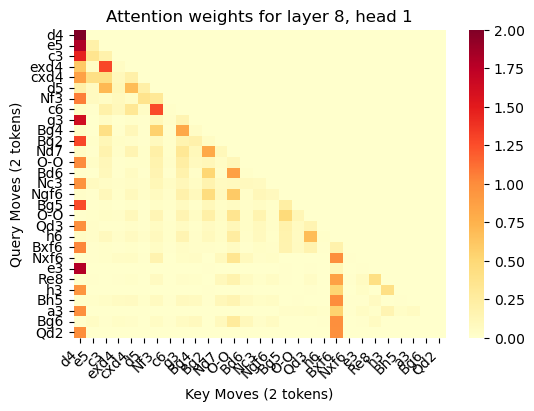

Visualizing attention for the entire move sequence:


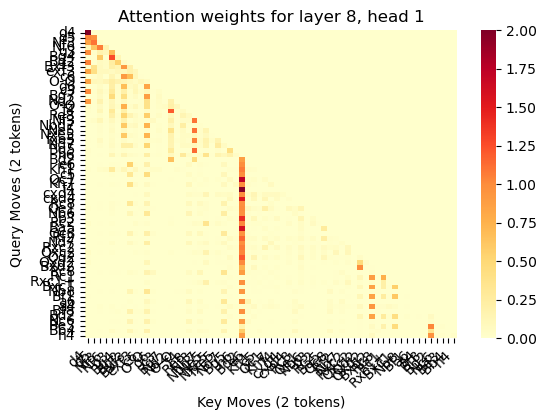

Visualizing attention for the entire move sequence:


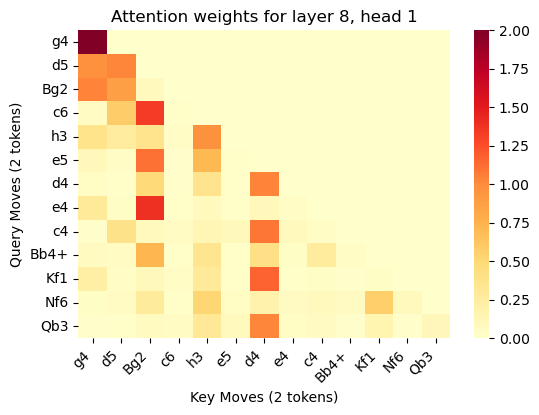

Visualizing attention for the entire move sequence:


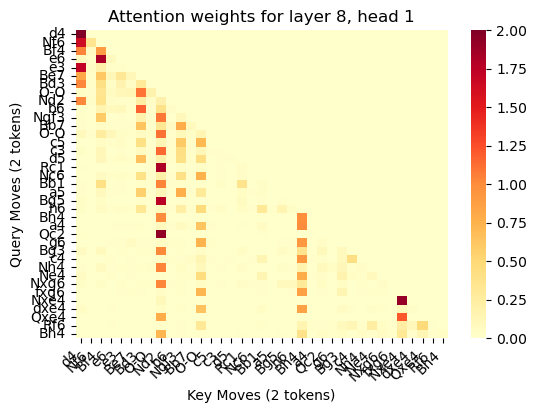

Visualizing attention for the entire move sequence:


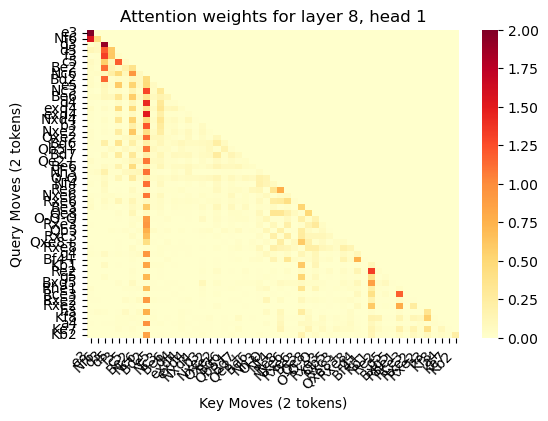

Visualizing attention for the entire move sequence:


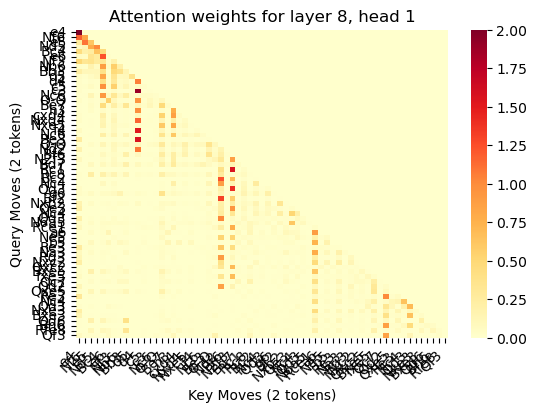

Visualizing attention for the entire move sequence:


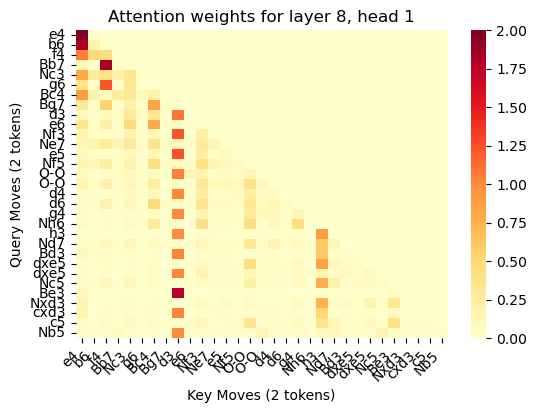

Visualizing attention for the entire move sequence:


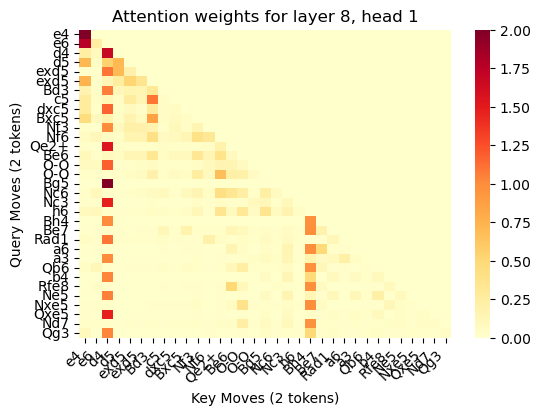

Visualizing attention for the entire move sequence:


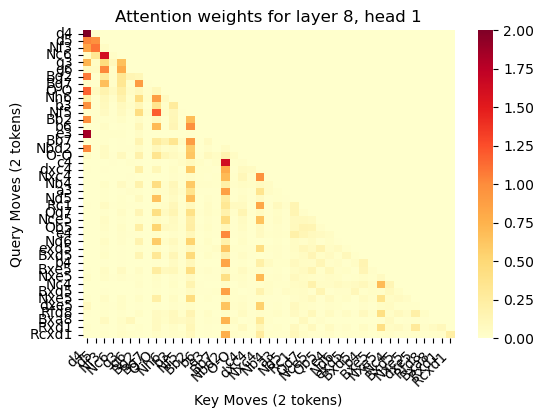

In [21]:
# Performing probe attention

for g1 in range(10):
    g = random.randint(0, 90000)
    a = ds['train']['text'][g][1:]
    b, c = chop_game_at_random_point(a)

    b1 = io.StringIO(b)
    game = pgn.read_game(b1)
    board = game.board()

    move_list = []
    for move in game.mainline_moves():
        move_list.append(board.uci(move))
        board.push(move)

    move_sequence = " ".join(move_list)

    '''
    print("Original sequence:")
    print(b)
    print("UCI move sequence:")
    print(move_sequence)
    '''

    probe_attention(move_sequence, query_key = 'moves')

    #generate_average_heatmap(move_sequence, average_over='heads')
    #generate_average_heatmap(move_sequence, average_over='layers')

In [ ]:
# -------------------------------
# Probing chess pieces positions
# ------------------------------


class PiecePositionProbe(torch.nn.Module):
    def __init__(self, model_size, num_positions=64):
        super().__init__()
        self.linear = torch.nn.Linear(model_size, 64)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, hidden_states):
        #hidden_states = hidden_states[0, -1, :]
        
        # Apply the probing classifier to predict the piece positions
        piece_logits = self.linear(hidden_states)
        # Apply sigmoid to get probabilities
        piece_positions_prob = self.sigmoid(piece_logits)

        return piece_positions_prob

    def reset_parameters(self):
        self.linear.reset_parameters()

In [ ]:
def train_probe(probe, optimizer, criterion, piece, games):
    model.eval()
    num_epochs = 1      #3
    batch_size = 16     #16

    if (piece == 'PAWN'):
        c_piece = chess.PAWN
    elif (piece == 'ROOK'):
        c_piece = chess.ROOK
    elif (piece == 'KNIGHT'):
        c_piece = chess.KNIGHT
    elif (piece == 'KING'):
        c_piece = chess.KING
    elif (piece == 'QUEEN'):
        c_piece = chess.QUEEN
    else:
        c_piece = chess.PAWN

    for epoch in range(num_epochs):
        total_loss = 0
        num_batches = 0
        
        for g in range(0, 2000, batch_size):
            batch_loss = 0
            valid_games = 0
            
            for i in range(g, min(g + batch_size, 2000)):
                b = chop_game_before_final_moves(str(games[i]))
                if b == 'skip':
                    continue
                
                b1 = io.StringIO(b)
                game = chess.pgn.read_game(b1)
                board = game.board()
                move_list = []
                for move in game.mainline_moves():
                    move_list.append(board.uci(move))
                    board.push(move)
                string_input = " ".join(move_list)

                squares_pieces1 = [1 if(board.piece_type_at(sq) == c_piece) else 0 for sq in chess.SQUARES]
                piece_positions = torch.tensor(squares_pieces1).float().unsqueeze(0)  # Shape: [1, 64]
                
                # Get model output
                outputs = get_model_output(string_input)
                hidden_states = outputs.hidden_states[0]
                
                # Forward pass
                output = probe(hidden_states)
                output = output[:, -1, :]  # Shape: [1, 64]
                
                loss = criterion(output, piece_positions)
                batch_loss += loss.item()
                valid_games += 1

            if valid_games > 0:
                batch_loss /= valid_games
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                total_loss += batch_loss
                num_batches += 1

        avg_loss = total_loss / num_batches if num_batches > 0 else 0
        print(f"Epoch {epoch + 1}/{num_epochs}: Average Loss = {avg_loss:.4f}")

    print("Training completed.")

In [ ]:
def test_probe(probe, piece, model, tokenizer, test_games, num_test_games=100):
    probe.eval()
    model.eval()
    
    total_accuracy = 0

    if (piece == 'PAWN'):
        c_piece = chess.PAWN
    elif (piece == 'ROOK'):
        c_piece = chess.ROOK
    elif (piece == 'KNIGHT'):
        c_piece = chess.KNIGHT
    elif (piece == 'KING'):
        c_piece = chess.KING
    elif (piece == 'QUEEN'):
        c_piece = chess.QUEEN
    else:
        c_piece = chess.PAWN
    

    with torch.no_grad():
        for i in range(num_test_games):
            b = chop_game_before_final_moves(str(test_games[i]))
            if b == 'skip':
                continue
            b1 = io.StringIO(b)
            game = chess.pgn.read_game(b1)
            board = game.board()
            move_list = []
            for move in game.mainline_moves():
                move_list.append(board.uci(move))
                board.push(move)
            string_input = " ".join(move_list)


            true_piece_positions = torch.tensor([1 if(board.piece_type_at(sq) == c_piece) else 0 for sq in chess.SQUARES]).float()

            board2 = chess.Board(fen="8/8/8/8/8/8/8/8 w - - 0 1")
            for square in chess.SQUARES:
                piece = board.piece_at(square)
                if piece and piece.piece_type == c_piece:
                    board2.set_piece_at(square, piece)

            print(board2)
            print("---------------------------")

            outputs = get_model_output(string_input)
            hidden_states = outputs.hidden_states[0]
            
            predicted_piece_positions = probe(hidden_states)
            predicted_piece_positions = predicted_piece_positions[:, -1, :] #.squeeze(0)  # Shape: [64]
            
            predicted_piece_positions = (predicted_piece_positions > 0.5).float()

            board3 = chess.Board(fen="8/8/8/8/8/8/8/8 w - - 0 1")
            #print(predicted_piece_positions.numpy()[1])
            for i in range(64):
                if (predicted_piece_positions.numpy()[0][i] == 1):
                    # Calculate the square position from the index
                    square = chess.SQUARES[i]
                    # Place a white pawn (change to chess.BLACK if you want black pawns)
                    board3.set_piece_at(square, chess.Piece(c_piece, chess.WHITE))     

            print(board3)
            print("---------------------------")     
            
            accuracy = (predicted_piece_positions == true_piece_positions).float().mean().item()
            total_accuracy += accuracy
    
    avg_accuracy = total_accuracy / num_test_games
    print(f"Average accuracy over {num_test_games} test games: {avg_accuracy:.4f}")


In [ ]:
file_path = "/home/sagemaker-user/anlp/prob1/lichess_Evd84363_2024-08-08.pgn"
#file_path = "/home/sagemaker-user/anlp/prob1/lichess_Mack9_2024-07-30.pgn"
games = read_pgn_file(file_path)

In [ ]:
vocab_path = "vocab.txt"
tokenizer = ChessTokenizer(vocab_path)
model = GPT2LMHeadModel.from_pretrained('shtoshni/gpt2-chess-uci')
initial_state = model.state_dict()

In [ ]:
#model.load_state_dict(initial_state)

In [ ]:
# Train probe

probe = PiecePositionProbe(model.config.hidden_size, 64)
optimizer = torch.optim.Adam(probe.parameters(), lr=1e-4)
criterion = torch.nn.BCELoss()

piece = 'KING'

train_probe(probe, optimizer, criterion, piece, games)

In [ ]:
file_path2 = "/home/sagemaker-user/anlp/prob1/lichess_Mack9_2024-07-30.pgn"
games2 = read_pgn_file(file_path2)

In [ ]:
# Test probe

piece = 'KING'
test_probe(probe, piece, model, tokenizer, games2, len(games2))

In [ ]:
# PAWN
# plain:    Average accuracy over 382 test games: 0.5467
# trained:  Average accuracy over 382 test games: 0.8201

# ROOK        
# plain:    Average accuracy over 382 test games: 0.5509
# trained:  Average accuracy over 382 test games: 0.9476

# KNIGHT   
# plain:    Average accuracy over 382 test games: 0.5110
# trained:  Average accuracy over 382 test games: 0.9714

# KING
# plain:    Average accuracy over 382 test games: 0.4557
# trained:  Average accuracy over 382 test games: 0.9379

# QUEEN
# plain:    Average accuracy over 382 test games: 0.5714
# trained:  Average accuracy over 382 test games: 0.9769


In [ ]:
def save_probe(probe):
    current_dir = "/home/sagemaker-user/anlp/prob1"
    file_path = os.path.join(current_dir, 'king_probe2.pth')
    torch.save(probe.state_dict(), file_path)
    print(f"Probe saved to {file_path}")

In [ ]:
save_probe(probe)

In [ ]:
device = 'cuda'
probe.load_state_dict(torch.load('king_probe2.pth', map_location=device))

In [ ]:
probe = PiecePositionProbe(model.config.hidden_size, 64)